* To investigate the impact of each forcing, i.e., river flow, tides, winds and Coriolis force on the plume properties and stratification.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,stormtools,tidetools,geo_tools,rivertools)
import datetime, os
from glob import glob
import pandas as pd
from IPython.core.display import Image,display
import matplotlib.pyplot as plt
import matplotlib.dates as md
import wind
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]

* First, take a look at the conditions of the selected simulations, which are Oct 2014 and May 2015, respectively.

# River flow at Hope

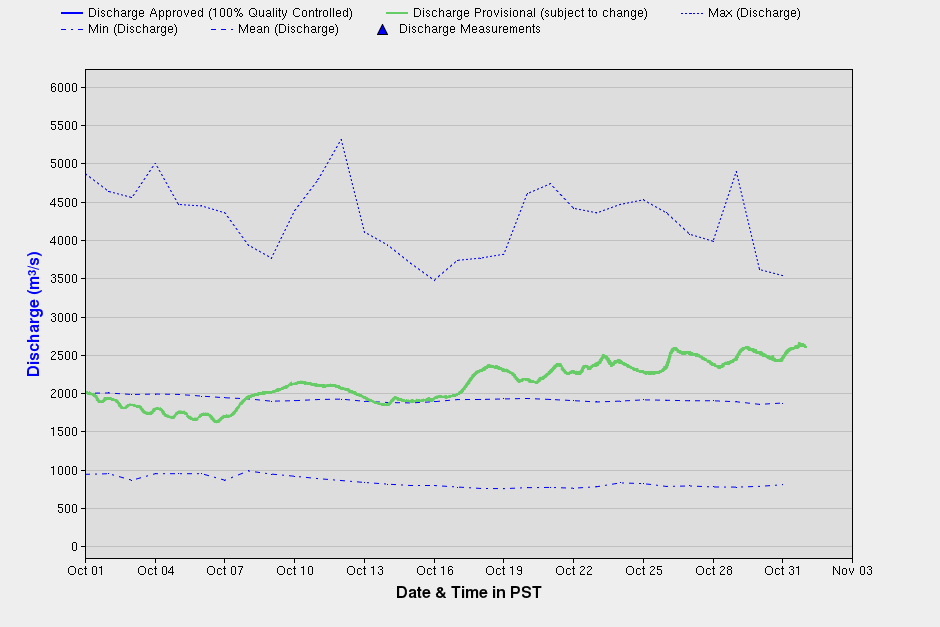

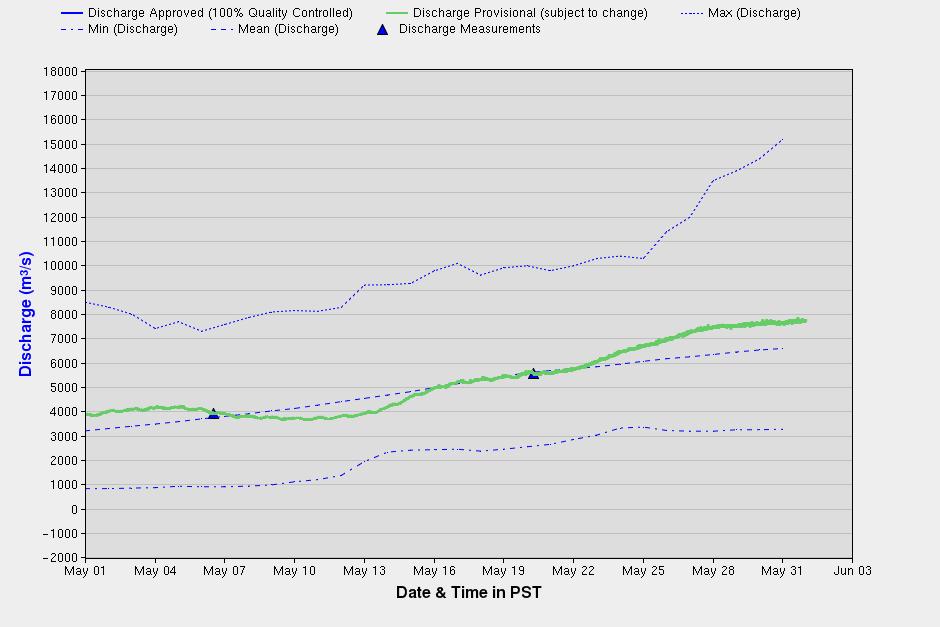

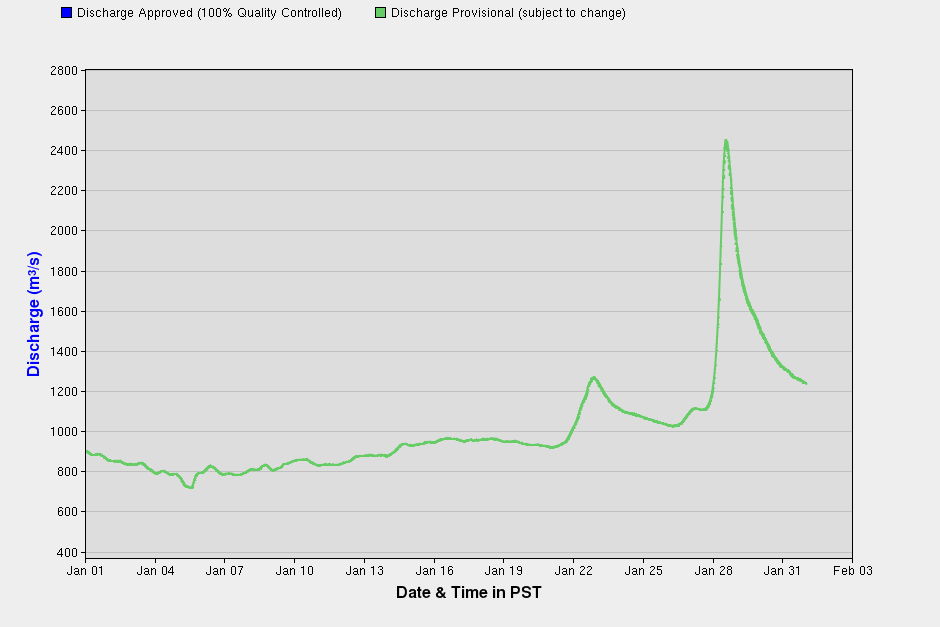

In [3]:
x = Image(filename='/ocean/jieliu/research/meopar/surface current/oct2014.png')
y = Image(filename='/ocean/jieliu/research/meopar/surface current/may2015.png')
z = Image(filename='/ocean/jieliu/research/meopar/surface current/Jan2016Discharge.png')
display(x, y, z)

In [4]:
def Get_River_Discharge(data_path,data_start,e1t,e2t, MONTH = 10):
    RUNOFFS = np.zeros(31)
    string = 1
    for t in np.arange(1,32): ## default tst -0, from start
        if string <10:
            real = nc.Dataset(data_path+str(data_start)+str(string)+'.nc')
            #print(data_path+str(data_start)+str(string),t)
        elif string >=10:
            real = nc.Dataset(data_path+str(string)+'.nc')
            #print(data_path+str(string),t)
        RUNOFFS[t-1] = real.variables['rorunoff'][0,500,395]*e1t[0,500,395]*e2t[0,500,395]/1000     
        string = string +1
    return RUNOFFS

In [5]:
def Get_River_Discharge(data_path,data_start,e1t,e2t, MONTH = 10):
    """Use this one if inlcude June 15~29, 2015"""
    RUNOFFS = np.zeros(31)
    string = 1
    for t in np.arange(1,32): ## default tst -0, from start
        if string <10:
            real = nc.Dataset(data_path+str(data_start)+str(string)+'.nc')
            #print(data_path+str(data_start)+str(string),t)
        elif string >=10 and string <=31:
            if MONTH !=6:
                real = nc.Dataset(data_path+str(string)+'.nc')
            elif MONTH ==6 and string ==31: ##June no 31st date
                real = nc.Dataset(data_path+str(string-1)+'.nc')
            else:
                real = nc.Dataset(data_path+str(string)+'.nc')
            #print(data_path+str(string),t)
        RUNOFFS[t-1] = real.variables['rorunoff'][0,500,395]*e1t[0,500,395]*e2t[0,500,395]/1000     
        string = string +1
    return RUNOFFS

In [6]:
e1t,e2t = rivertools.get_bathy_cell_size(grid='/ocean/jieliu/research/meopar/nemo-forcing/grid/'
         'coordinates_seagrid_SalishSea.nc')

In [7]:
data_path = '/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d'
data_start = 0
RUNOFFS = Get_River_Discharge(data_path,data_start,e1t,e2t,MONTH =10)

In [8]:
data_path = '/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2015m05d'
data_start = 0
RUNOFFS_may = Get_River_Discharge(data_path,data_start,e1t,e2t, MONTH =5)

In [9]:
data_path = '/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2016m01d'
data_start = 0
RUNOFFS_jan = Get_River_Discharge(data_path,data_start,e1t,e2t, MONTH= 1)

In [10]:
data_path = '/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2015m06d'
data_start = 0
RUNOFFS_june = Get_River_Discharge(data_path,data_start,e1t,e2t, MONTH= 6)

# Tides at PA

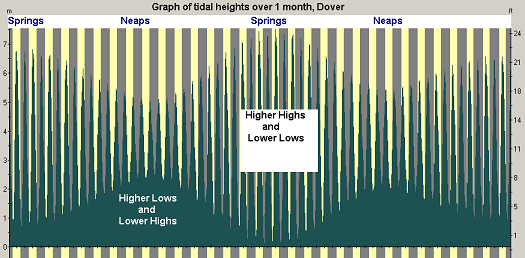

In [11]:
Image(filename='/ocean/jieliu/research/meopar/surface current/tideneapsspringgraph.PNG')

In [12]:
## load t_tide
tfile = '/ocean/jieliu/research/meopar/tools/SalishSeaNowcast/tidal_predictions/\
Point Atkinson_t_tide_compare8_31-Dec-2013_02-Dec-2015.csv'
ttide, msl = stormtools.load_tidal_predictions(tfile)

In [5]:
def find_ind_tide(run_low, run_up, run_label1,run_label2):
    """To find index of ttide within a time range"""
    run_low = run_low.replace(tzinfo=pytz.utc) ## convert model datetime to tzinfo=<UTC>
    run_up = run_up.replace(tzinfo=pytz.utc) ## the time i want to label on the plot
    run_label1 = run_label1.replace(tzinfo=pytz.utc)
    run_label2 = run_label2.replace(tzinfo=pytz.utc)
    ttide_dt  = ttide.time.dt.to_pydatetime() ## convert ttide.time (pandas) to datetime
    for i in range(len(ttide_dt)):
        if ttide_dt[i]== run_low:
            low_ind = i
        if ttide_dt[i]== run_up:
            up_ind = i  
        if ttide_dt[i]== run_label1:
            lab_ind1 = i  
        if ttide_dt[i]== run_label2:
            lab_ind2 = i  
    return low_ind, up_ind, lab_ind1,lab_ind2

In [6]:
run_low = datetime.datetime(2014,9,1)
run_up = datetime.datetime(2014,11,1)
run_label1 = datetime.datetime(2014,9,24)
run_label2 = datetime.datetime(2014,10,1)
low_ind,up_ind,lab_ind1,lab_ind2 = find_ind_tide(run_low,run_up,run_label1,run_label2)

(-3.5, 3.5)

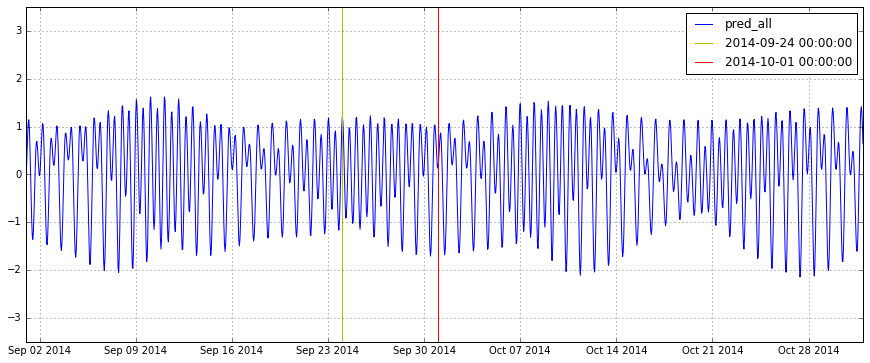

In [7]:
fig, ax = plt.subplots(1,1,figsize = (15,6))
ax.plot(ttide.time[low_ind:up_ind], ttide.pred_all[low_ind:up_ind])
ax.plot([ttide.time[lab_ind1],ttide.time[lab_ind1]],[-3.5,3.5],'y-',label = run_label1)
ax.plot([ttide.time[lab_ind2],ttide.time[lab_ind2]],[-3.5,3.5],'r-',label = run_label2)
ax.grid('on')
ax.legend()
ax.set_ylim(-3.5,3.5)

* spin-up period is in Springs, but Spring-Neap cycle is not very significant in fall.

(-3.5, 3.5)

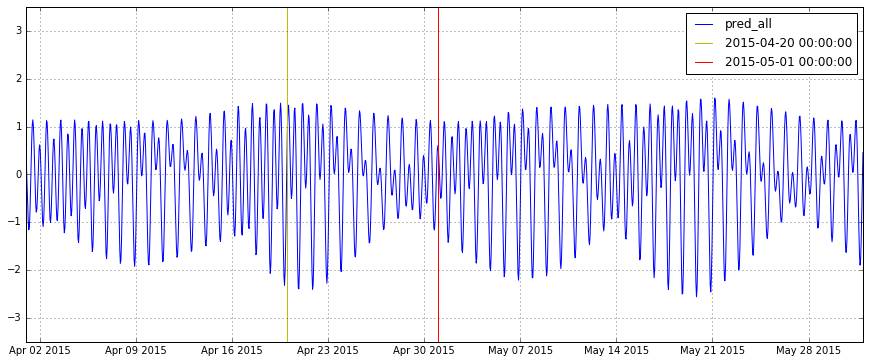

In [8]:
run_low = datetime.datetime(2015,4,1)
run_up = datetime.datetime(2015,6,1)
run_label1 = datetime.datetime(2015,4,20)
run_label2 = datetime.datetime(2015,5,1)
low_ind,up_ind,lab_ind1,lab_ind2 = find_ind_tide(run_low,run_up,run_label1,run_label2)
fig, ax = plt.subplots(1,1,figsize = (15,6))
ax.plot(ttide.time[low_ind:up_ind], ttide.pred_all[low_ind:up_ind])
ax.plot([ttide.time[lab_ind1],ttide.time[lab_ind1]],[-3.5,3.5],'y-',label = run_label1)
ax.plot([ttide.time[lab_ind2],ttide.time[lab_ind2]],[-3.5,3.5],'r-',label = run_label2)
ax.grid('on')
ax.legend()
ax.set_ylim(-3.5,3.5)

* spin-up period cross Spring-Neap tidal modulation period.

* ttide doesn't include days after Dec, 2015. Use modelled ssh at PA instead.

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(-3.5, 3.5)

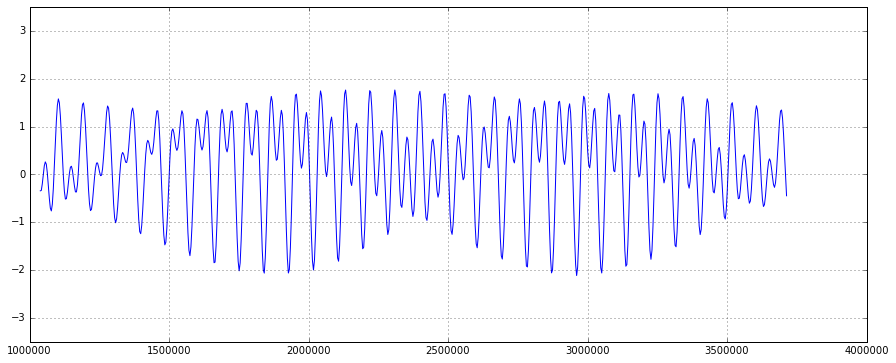

In [17]:
grid_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')
ssh = grid_T.variables['sossheig']
timesteps = grid_T.variables['time_counter'][:]
fig, ax = plt.subplots(1,1,figsize = (15,6))
ax.plot(timesteps,ssh[:,86,89],'-b')
ax.grid('on')
ax.legend()
ax.set_ylim(-3.5,3.5)

# Winds at Sand Heads

In [29]:
OP = nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m10d01.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]

In [30]:
def get_winds(start, end, start2, end2, stations,stationsOP,OPlon,OPlat,filesOP,duration,key1,key2,sax,eax,day,hour,minute):
    #compare wind speed and direction for data indicated by key1 and key2
    #time limits on axis given by sax,eax, label the duration range of 
    #drifter and particle floats.
    ## obs
    wind_speed = {}; wind_dir = {}; time = {}; lat={}; lon={}; press={}; temp={}; therm={};
    solar={}; precip={}; qair={}

    #start = '1-Oct-2014'; end = '1-Oct-2014';
    #start2 = '31-Oct-2014'; end2 = '31-Oct-2014';

    #stations = ['Sandheads']

    for key in stations:
        [wind_speed[key],wind_dir[key],temp[key],time[key], 
         lat[key], lon[key]] = stormtools.get_EC_observations(key,start,end)
        [ws,wd,T,t, la, lo] = stormtools.get_EC_observations(key,start2,end2)
        wind_speed[key]=np.append(wind_speed[key],ws)
        wind_dir[key]=np.append(wind_dir[key],wd)
        time[key]=np.append(time[key],t)
        temp[key]=np.append(temp[key],T)

    for (obs, modOP) in zip(stations,stationsOP):    
        [j,i]=wind.find_model_point(lon[obs],lat[obs],OPlon,OPlat)
        lon[modOP] = OPlon[j,i]
        lat[modOP]=OPlat[j,i]

        [wind_speed[modOP],wind_dir[modOP],time[modOP],
         press[modOP],temp[modOP],solar[modOP],
         therm[modOP],qair[modOP],precip[modOP]] = wind.compile_OP(filesOP,j,i)    
    return wind_speed,time

In [16]:
import glob
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m10d*.nc')
filesOP.sort(key=os.path.basename)
start = '27-Oct-2014'; end = '31-Oct-2014';
start2 = '31-Oct-2014'; end2 = '31-Oct-2014';
endd = '31-Oct-2014';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')
sp,ti =get_winds(start, end, start2, end2,stations,stationsOP,OPlon,OPlat,filesOP,\
27,'Sandheads','Sandheads_OP',sax,eax,8, 16, 0)

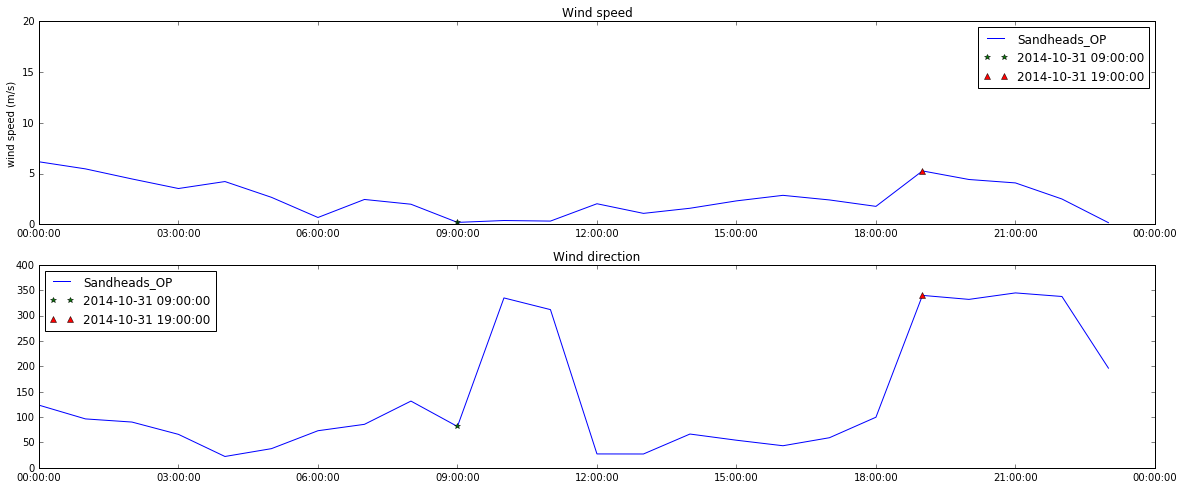

In [5]:
t1= datetime.datetime(2014,10,31,9)
t2= datetime.datetime(2014,10,31,19)
time =wind.compare_winds_label(start, end, start2, end2,stations,stationsOP,OPlon,OPlat,filesOP,\
                       t1,t2,27,'Sandheads','Sandheads_OP',sax,eax,8, 16, 0)

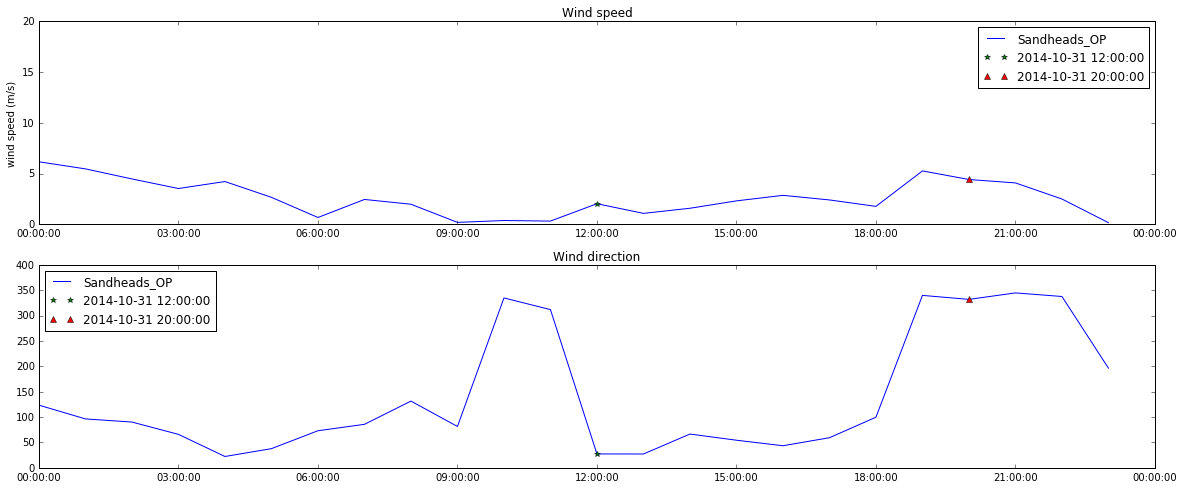

In [4]:
t1= datetime.datetime(2014,10,31,12)
t2= datetime.datetime(2014,10,31,20)
time =wind.compare_winds_label(start, end, start2, end2,stations,stationsOP,OPlon,OPlat,filesOP,\
                       t1,t2,27,'Sandheads','Sandheads_OP',sax,eax,8, 16, 0)

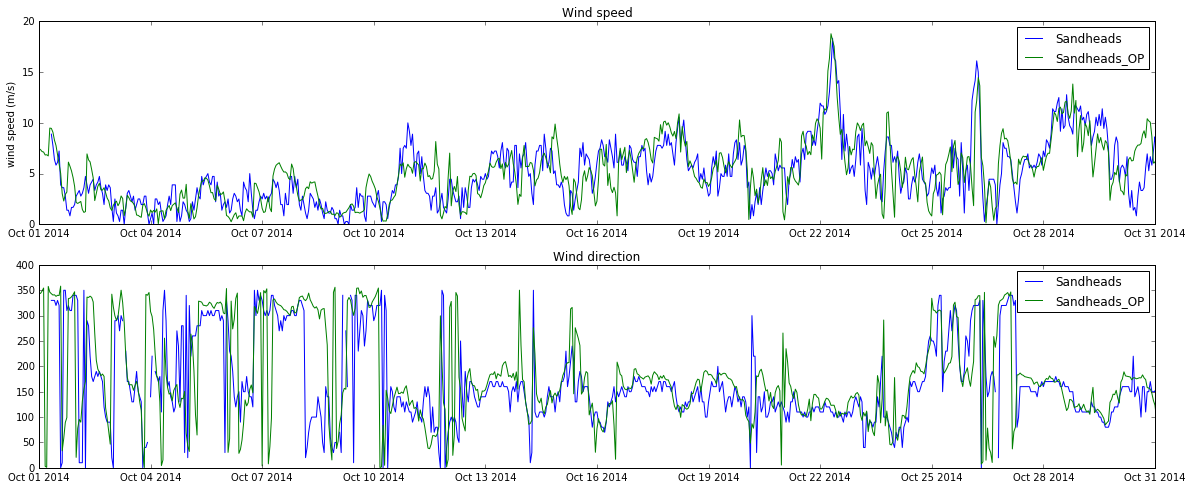

In [5]:
import glob
## OCT 2014
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m10d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-Oct-2014'; end = '31-Oct-2014';
start2 = '31-Oct-2014'; end2 = '31-Oct-2014';
endd = '31-Oct-2014';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

ax =wind.compare_winds(start, end, start2, end2,stations,stationsOP,OPlon,OPlat,filesOP,\
                       27,'Sandheads','Sandheads_OP',sax,eax,8, 16, 0)

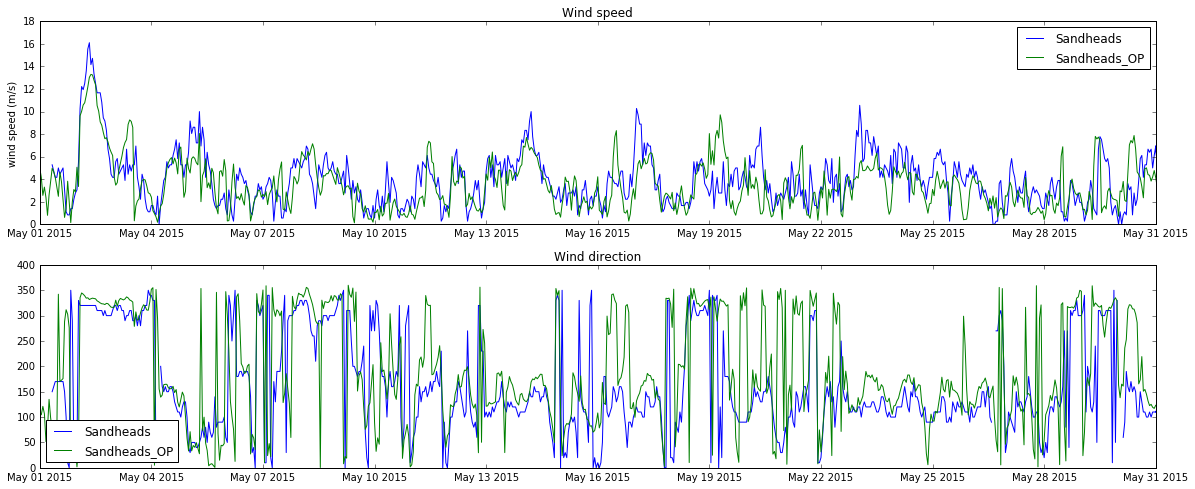

In [12]:
## MAY 2015
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m05d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-May-2015'; end = '31-May-2015';
start2 = '31-May-2015'; end2 = '31-May-2015';
endd = '31-May-2015';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

ax =wind.compare_winds(start, end, start2, end2,stations,stationsOP,OPlon,OPlat,filesOP,\
                       27,'Sandheads','Sandheads_OP',sax,eax,8, 16, 0)

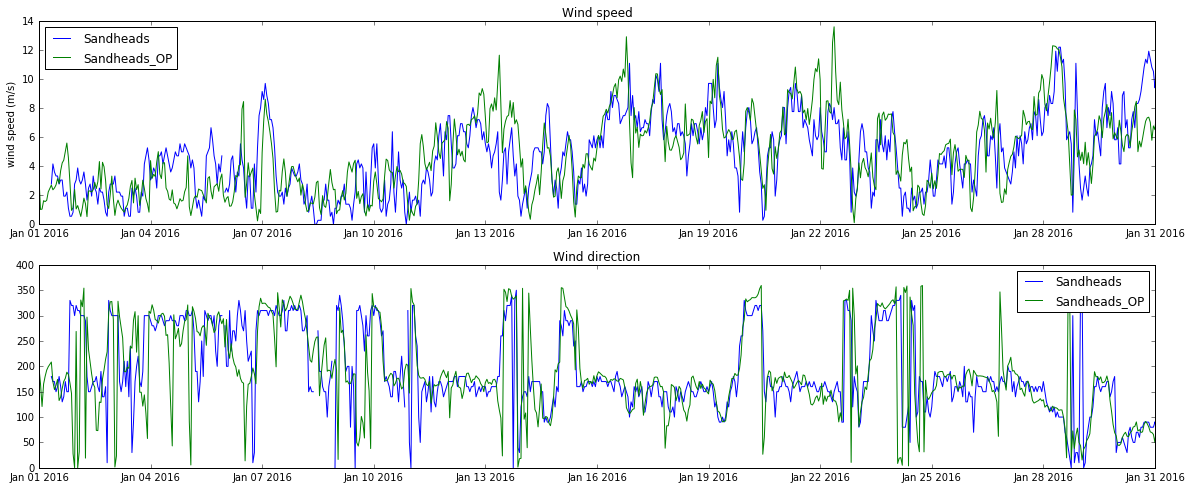

In [5]:
## JAN 2016
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2016m01d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-Jan-2016'; end = '31-Jan-2016';
start2 = '31-Jan-2016'; end2 = '31-Jan-2016';
endd = '31-Jan-2016';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

ax =wind.compare_winds(start, end, start2, end2,stations,stationsOP,OPlon,OPlat,filesOP,\
                       27,'Sandheads','Sandheads_OP',sax,eax,8, 16, 0)

In [11]:
def get_OPwinds(stationsOP,OPlon,OPlat,filesOP,j,i,duration,sax,eax):
    "This function was made to get model winds' speed and direction"
    wind_speed = {}; wind_dir = {}; time = {}; lat={}; lon={}; press={}; temp={}; therm={};
    solar={}; precip={}; qair={}; lon = {};lat = {};

    for  modOP in stationsOP:   
        
        [j,i]=wind.find_model_point(X[j,i],Y[j,i],OPlon,OPlat)
        lon[modOP] = OPlon[j,i]
        lat[modOP]=OPlat[j,i]
        print(j,i,lon[modOP],lat[modOP])

        [wind_speed[modOP],wind_dir[modOP],time[modOP],
         press[modOP],temp[modOP],solar[modOP],
         therm[modOP],qair[modOP],precip[modOP]] = wind.compile_OP(filesOP,j,i)    
      
    return wind_speed, wind_dir

In [12]:
import glob
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m10d*.nc')
filesOP.sort(key=os.path.basename)

OP = nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m10d01.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]

start = '1-Oct-2014'; end = '31-Oct-2014';
start2 = '31-Oct-2014'; end2 = '31-Oct-2014';
endd = '31-Oct-2014';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speed,wind_dir =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                            27,sax,eax)

135 151 -123.302707487 49.0907848354


In [13]:
## convert direction Oct
wind_dir_correct = []
for dire in wind_dir['Sandheads_OP']:
    dire_corre =  450 - dire
    wind_dir_correct.append(dire_corre)
## load into a pandas frame
df_oct = pd.DataFrame({"speed": wind_speed['Sandheads_OP'], "direction": wind_dir_correct})

In [14]:
u_oct = np.zeros([1,len(df_oct)])
v_oct = np.zeros([1,len(df_oct)])
for i in np.arange(len(df_oct)):
    u_oct[0,i] = df_oct.speed[i] * np.cos((450-df_oct.direction[i])*np.pi/180)
    v_oct[0,i] = df_oct.speed[i] * np.sin((450-df_oct.direction[i])*np.pi/180)

In [15]:
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m05d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-May-2015'; end = '31-May-2015';
start2 = '31-May-2015'; end2 = '31-May-2015';
endd = '31-May-2015';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speedMay,wind_dirMay =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                       27,sax,eax)

135 151 -123.302707487 49.0907848354


In [16]:
## May
wind_dir_correctMay = []
for dire in wind_dirMay['Sandheads_OP']:
    dire_corre = 450 - dire
    wind_dir_correctMay.append(dire_corre)
df_may = pd.DataFrame({"speed": wind_speedMay['Sandheads_OP'], "direction": wind_dir_correctMay})

In [17]:
u_may = np.zeros([1,len(df_may)])
v_may = np.zeros([1,len(df_may)])
for i in np.arange(len(df_oct)):
    u_may[0,i] = df_may.speed[i] * np.cos((450-df_may.direction[i])*np.pi/180)
    v_may[0,i] = df_may.speed[i] * np.sin((450-df_may.direction[i])*np.pi/180)

In [18]:
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2016m01d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-Jan-2016'; end = '31-Jan-2016';
start2 = '31-Jan-2016'; end2 = '31-Jan-2016';
endd = '31-Jan-2016';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speedJan,wind_dirJan =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                       27,sax,eax)

135 151 -123.302707487 49.0907848354


In [19]:
## Jan
wind_dir_correctJan = []
for dire in wind_dirJan['Sandheads_OP']:
    dire_corre =  450 - dire 
    wind_dir_correctJan.append(dire_corre)
df_jan = pd.DataFrame({"speed": wind_speedJan['Sandheads_OP'], "direction": wind_dir_correctJan})

In [20]:
u_jan = np.zeros([1,len(df_jan)])
v_jan = np.zeros([1,len(df_jan)])
for i in np.arange(len(df_jan)):
    u_jan[0,i] = df_jan.speed[i] * np.cos((450-df_jan.direction[i])*np.pi/180)
    v_jan[0,i] = df_jan.speed[i] * np.sin((450-df_jan.direction[i])*np.pi/180)

In [21]:
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m06d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-Jun-2015'; end = '30-Jun-2015';
start2 = '30-Jun-2015'; end2 = '30-Jun-2015';
endd = '30-Jun-2016';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speedJun,wind_dirJun =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                       27,sax,eax)

135 151 -123.302707487 49.0907848354


In [22]:
## Jun
wind_dir_correctJun = []
for dire in wind_dirJun['Sandheads_OP']:
    dire_corre =  450 - dire 
    wind_dir_correctJun.append(dire_corre)
df_jun = pd.DataFrame({"speed": wind_speedJun['Sandheads_OP'], "direction": wind_dir_correctJun})

In [23]:
u_jun = np.zeros([1,len(df_jun)])
v_jun = np.zeros([1,len(df_jun)])
for i in np.arange(len(df_jun)):
    u_jun[0,i] = df_jun.speed[i] * np.cos((450-df_jun.direction[i])*np.pi/180)
    v_jun[0,i] = df_jun.speed[i] * np.sin((450-df_jun.direction[i])*np.pi/180)

In [24]:
ssh = {}; 
oct_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
may_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
jan_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

for gridT, string in zip([oct_T,may_T,jan_T], ['oct','may','jan']):
    ssh[string] = gridT.variables['sossheig'][:,86,89]
A = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/24hrs_norles/15jun15/SalishSea_1h_20150615_20150615_grid_T.nc')
B = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NWSmoorerunMoreSubdomain/1hplume06160629smooLargestgridT.nc')
ssh['june'] = np.zeros(360)
ssh['june'][0:24] = A.variables['sossheig'][:,466,329]
ssh['june'][24:] = B.variables['sossheig'][:,117,129]

In [25]:
def plot_runoff_tides_winds(t_start,t_end,t_runoff,t_wind,runoffs,ssh,u_wind,v_wind,ylimUP,wind_speed,column = 'yes'):
    """
    Plot the daily river discharge at Hope as used for main arm of Fraser, tidal height at PA and wind
    at Sandheads, if column is 'yes', then add column plot, else, get rid of this , wind_speed is the model wind speed
    and add them onto the plot"""
    fig, axs = plt.subplots(3,1, figsize = (12,13))
    ax = axs[0] ## river discharge
    ax.plot(t_runoff,runoffs[:],'k-*')
    ax.plot([t_runoff[0],t_runoff[-1]],[np.nanmean(runoffs),np.nanmean(runoffs)], 'b--')
    ax.set_ylabel('Fraser discharge $\mathrm{(m^3s^{-1})}$') 
    ax.set_ylim([0,ylimUP]) 
    ax = axs[1] ## ssh at PA
    ax.plot(t_wind,ssh,color = 'k')
    ax.set_ylabel('Model SSH at PA (m)')
    ax = axs[2] ## wind at Sandheads
    quiver = ax.quiver(md.date2num(t_wind),np.ones(1),u_wind[:],v_wind[:],scale = 80,width=0.0017, color='k') 
    ax.set_ylabel('Model wind vector')
    plt.xticks(rotation=45)
    ax.set_xlabel('Date')
    
    ax3 = ax.twinx()
    ax3.plot(t_wind,wind_speed) ## add wind speed onto the plot
    ax3.set_ylabel('Model wind speed $\mathrm{(ms^{-1})}$', color = 'b')
    ax.quiverkey(quiver,md.date2num(t_wind)[4],1.025, 5, '',coordinates='data', color='black', labelcolor='black')
    ax.text(md.date2num(t_wind)[4],1.03,'5 $\mathrm{ms^{-1}}$', fontsize = 20)
    plt.setp(ax.get_yticklabels(), visible=False)
    for tl in ax3.get_yticklabels():
        tl.set_color('b')
    for ax in axs: ## set xlims
        ax.set_xlim([t_start,t_end])
    for ax in axs[:-1]: ## remove x ticks for the first two plots
        plt.setp(ax.get_xticklabels(), visible=False)
    if column is 'yes':
        for i, c in zip(np.arange(3),['g','c','r']):
            for ax in axs: ## add period columns
                ax.axvspan(a[i], b[i], color=c, alpha=0.5, lw=0)
    
    plt.show()

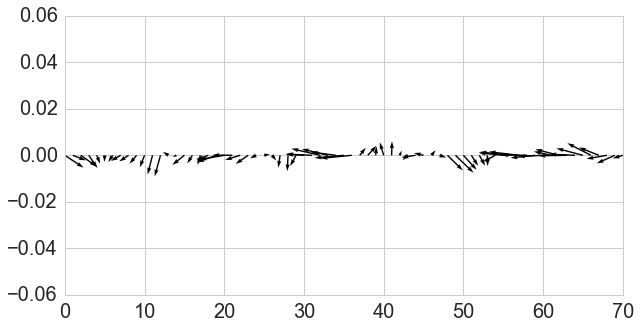

In [53]:
fig,ax = plt.subplots(1,1,figsize = (10,5))
quiver = ax.quiver(u_jan[:,168:239],v_jan[:,168:239],scale = 80,width=0.0025, color='k')

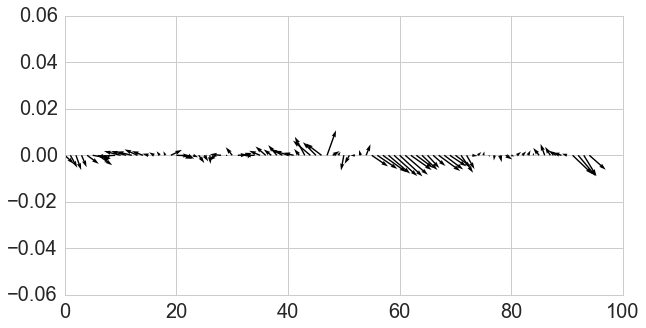

In [54]:
fig,ax = plt.subplots(1,1,figsize = (10,5))
quiver = ax.quiver(u_oct[:,48:143],v_oct[:,48:143],scale = 80,width=0.0025, color='k')

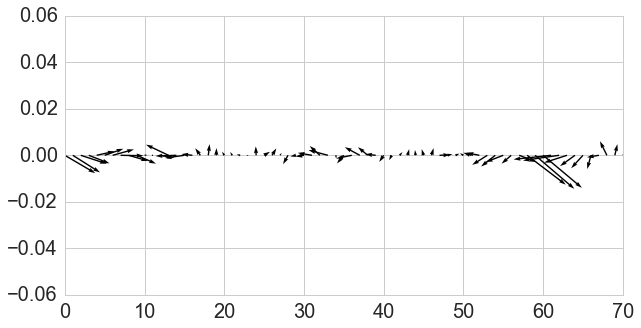

In [55]:
fig,ax = plt.subplots(1,1,figsize = (10,5))
quiver = ax.quiver(u_may[:,192:263],v_may[:,192:263],scale = 80,width=0.0025, color='k')

# Jan

In [26]:
t_start = datetime.datetime(2016,1,1,0,30)
t_end = datetime.datetime(2016,1,31,23,30)
t_runoff = [datetime.datetime(2016,1,d,12,30) for d in np.arange(1,32,1)]
t_wind = [datetime.datetime(2016,1,d,h,30) for d in np.arange(1,32,1) for h in np.arange(0,24)]

In [27]:
a = [datetime.datetime(2016,1,8,0,30),datetime.datetime(2016,1,17,0,30),datetime.datetime(2016,1,27,0,30)]
b = [datetime.datetime(2016,1,10,23,30),datetime.datetime(2016,1,19,23,30),datetime.datetime(2016,1,28,21,30)]

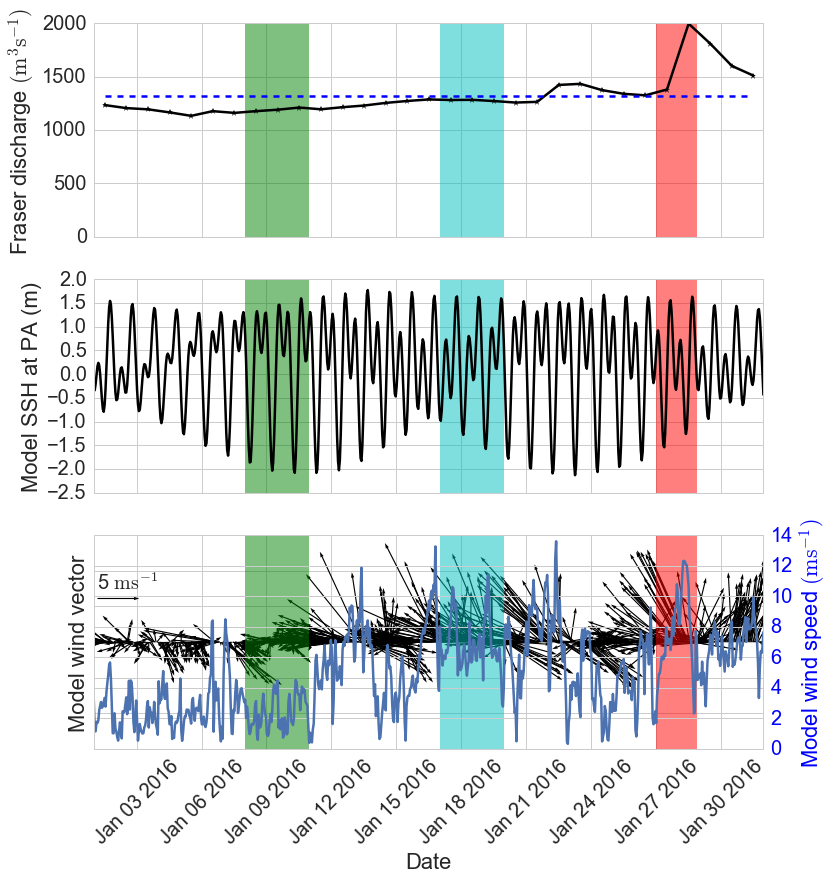

In [28]:
plot_runoff_tides_winds(t_start,t_end,t_runoff,t_wind,RUNOFFS_jan,ssh['jan'],u_jan,v_jan,2000,wind_speedJan['Sandheads_OP'])

# Oct

In [29]:
t_start = datetime.datetime(2014,10,1,0,30)
t_end = datetime.datetime(2014,10,31,23,30)
t_runoff = [datetime.datetime(2014,10,d,12,30) for d in np.arange(1,32,1)]
t_wind = [datetime.datetime(2014,10,d,h,30) for d in np.arange(1,32,1) for h in np.arange(0,24)]

In [30]:
a = [datetime.datetime(2014,10,3,0,30),datetime.datetime(2014,10,18,0,30),datetime.datetime(2014,10,21,0,30)]
b = [datetime.datetime(2014,10,6,23,30),datetime.datetime(2014,10,20,23,30),datetime.datetime(2014,10,23,21,30)]

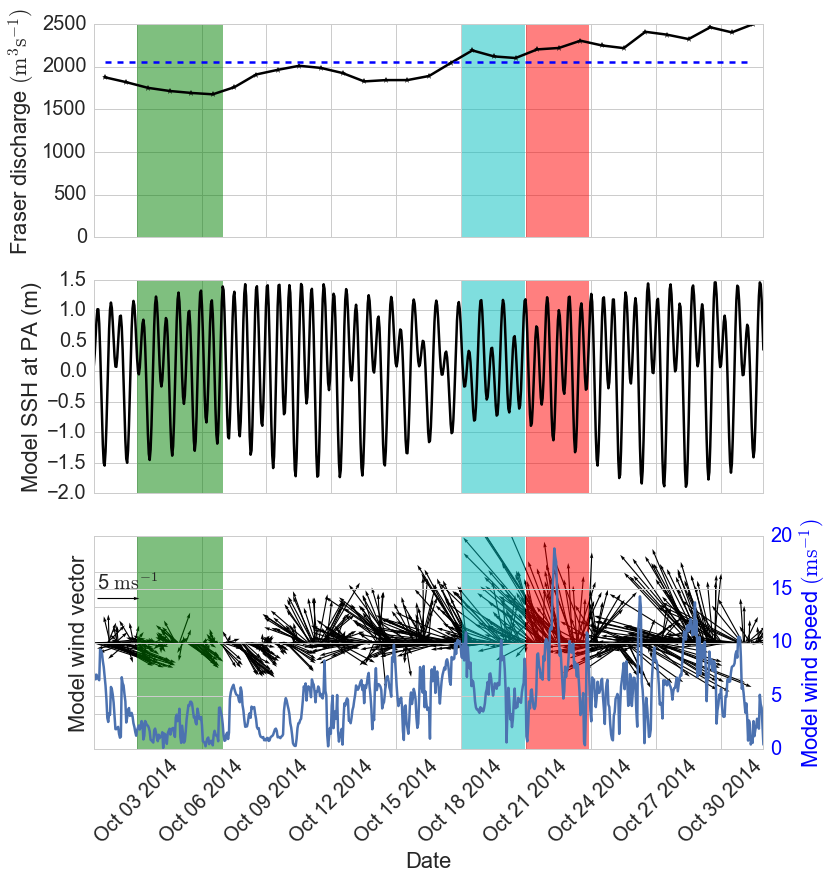

In [31]:
plot_runoff_tides_winds(t_start,t_end,t_runoff,t_wind,RUNOFFS,ssh['oct'],u_oct,v_oct,2500,wind_speed['Sandheads_OP'])

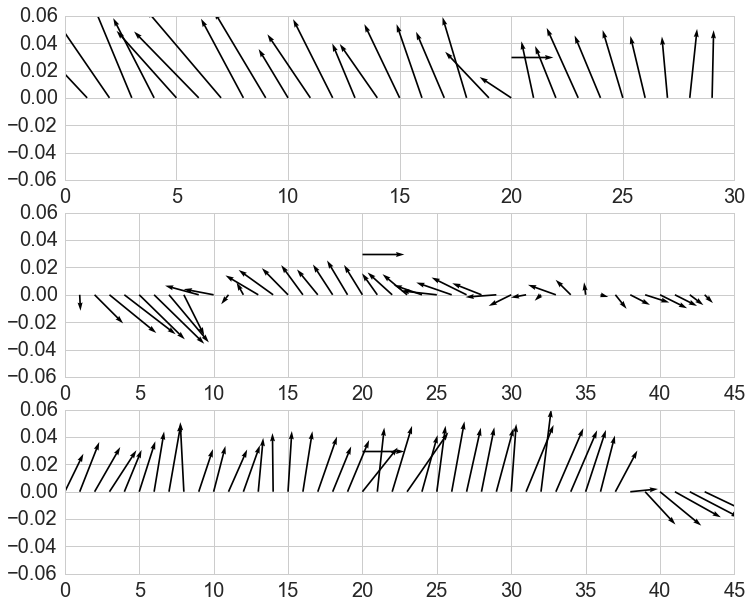

In [59]:
## This is what I want to check wind direction on Oct: 679, May: 733 and Jan :741, because 
## I found at those time the plume boundary are different, I want to relate them to upwelling/
## downwelling advected offshore.
fig,axs = plt.subplots(3,1,figsize= (12,10))
ax = axs[0]
quiver = ax.quiver(u_oct[:,660:690],v_oct[:,660:690],scale = 80,width=0.0025, color='k')
ax.quiverkey(quiver,20,0.03, 5, '',coordinates='data', color='black', labelcolor='black')

ax = axs[1]
quiver = ax.quiver(u_may[:,700:744],v_may[:,700:744],scale = 80,width=0.0025, color='k')
ax.quiverkey(quiver,20,0.03, 5, '',coordinates='data', color='black', labelcolor='black')

ax = axs[2]
quiver = ax.quiver(u_jan[:,700:744],v_jan[:,700:744],scale = 80,width=0.0025, color='k')
ax.quiverkey(quiver,20,0.03, 5, '',coordinates='data', color='black', labelcolor='black')

# May

In [32]:
t_start = datetime.datetime(2015,5,1,0,30)
t_end = datetime.datetime(2015,5,31,23,30)
t_runoff = [datetime.datetime(2015,5,d,12,30) for d in np.arange(1,32,1)]
t_wind = [datetime.datetime(2015,5,d,h,30) for d in np.arange(1,32,1) for h in np.arange(0,24)]

In [33]:
a = [datetime.datetime(2015,5,9,0,30),datetime.datetime(2015,5,19,0,30),datetime.datetime(2015,5,2,0,30)]
b = [datetime.datetime(2015,5,11,23,30),datetime.datetime(2015,5,21,23,30),datetime.datetime(2015,5,3,21,30)]

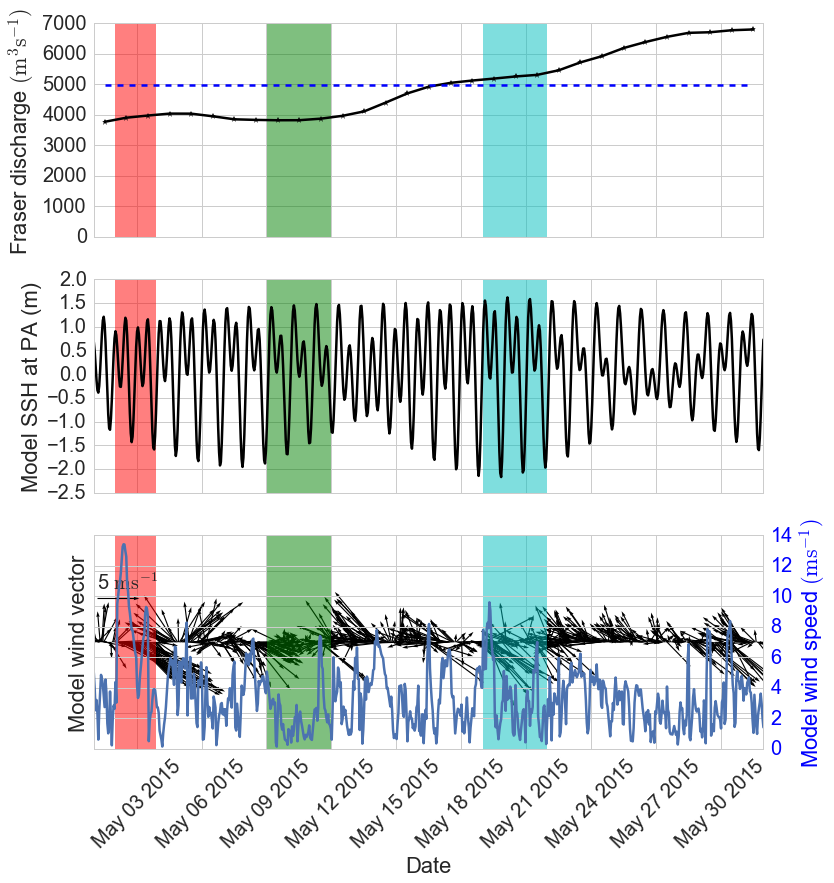

In [34]:
plot_runoff_tides_winds(t_start,t_end,t_runoff,t_wind,RUNOFFS_may,ssh['may'],u_may,v_may,7000,wind_speedMay['Sandheads_OP'])

# June 15~29

In [35]:
t_start = datetime.datetime(2015,6,15,0,30)
t_end = datetime.datetime(2015,6,29,23,30)
t_runoff = [datetime.datetime(2015,6,d,12,30) for d in np.arange(15,30,1)]
t_wind = [datetime.datetime(2015,6,d,h,30) for d in np.arange(15,30,1) for h in np.arange(0,24)]
wind_june = wind_speedJun['Sandheads_OP'][24*14:24*29]

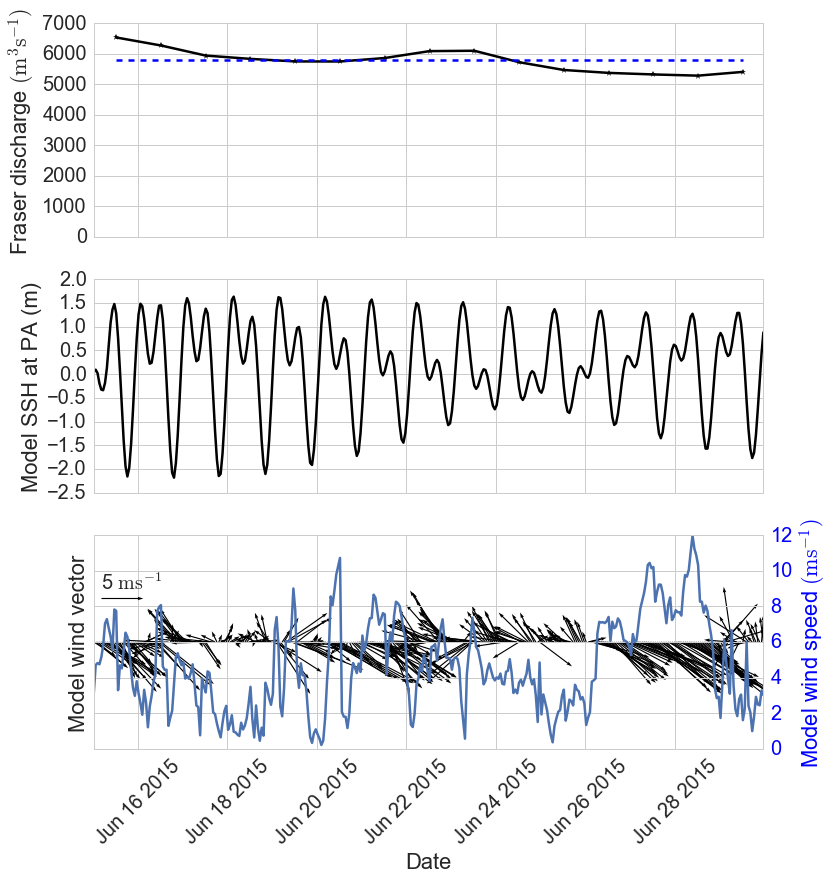

In [36]:
plot_runoff_tides_winds(t_start,t_end,t_runoff,t_wind,RUNOFFS_june[15:30],ssh['june'],\
                        u_jun[:,24*14:24*29],v_jun[:,24*14:24*29],7000, wind_june,column='no')